In [3]:
library(ape)
library(tidyverse)
library(glue)

library(phytools)

library(caper)
library(lme4)
library(lmerTest)
library(lmtest)
library(MuMIn)

library(LaplacesDemon)
library(MASS)
library(glmmTMB)
library(DHARMa)

library(caTools)
library(car)
library(quantmod)
library(MASS)
library(corrplot)
library(performance)

options(xts.warn_dplyr_breaks_lag = FALSE)
library(comprehenr)

library(glmmTMB) 

library(lavaan)
library(piecewiseSEM)

This is lavaan 0.6-15
lavaan is FREE software! Please report any bugs.


Attaching package: ‘lavaan’


The following object is masked from ‘package:TTR’:

    growth



  This is piecewiseSEM version 2.3.0.


  Questions or bugs can be addressed to <LefcheckJ@si.edu>.



In [2]:
# Noa's suggestion: can we maybe binaize polyploid frequency? has polyploids or not?
do_weighted = TRUE
include_metadata = TRUE
# missing data % tunred significant in connectance and modularity prediction, suggesting that there is too much missing data and that we should make the thresohld higher (e.g. - 0.2 such that this variable is no longer significant)
max_missing_threshold = 0.7
min_classified_threshold = 3
min_poly_threhold = 0
min_di_threshold = 0

weighted_str = "unweighted" 
if (do_weighted)
    {
    weighted_str = "weighted" 
}

features_of_interest = c("null_standardized_weighted.NODF", # nestedness measure
                     "null_standardized_weighted.connectance", 
                     "null_standardized_modularity",
                     "null_standardized_robustness.LL")

metadata_features = c(c("pd", "network_size", # network phylogenetic diversity and size are continuous and they will also act as fixed effects
                        "highest_pollinator_rank_index", "climate_category"), # two random effects correspnoding to network resolution and network area (only in terms of climate - warm, arid, polar, boreal or equatorial)
                      c("Climate_PC1", "Climate_PC2", "Climate_PC3", "species_richness"), 
                       c('frac_herb','frac_missing_herb',
                        'frac_flw_rest','frac_missing_flw_rest',
                        'frac_multi_flw','frac_missing_multi_flw',
                        'frac_symmetric','frac_missing_symmetric',
                        'frac_sc','frac_missing_sc'))
ploidy_predictor="is_polyploid_poly_frac"
geo_str = "and_metadata_"
if (!include_metadata)
{
    metadata_features = c("pd", "network_size", "highest_pollinator_rank_index")
    geo_str = ""
}
random_vars = c("highest_pollinator_rank_index", "climate_category")

data_path <- glue("../../../data/statistical_analysis/network_level/processed_features_with_ploidy_classification_on_{weighted_str}_networks.csv")
res_path = glue("../../../data/statistical_analysis/network_level/test_results_{geo_str}on_{weighted_str}_networks_{max_missing_threshold}_missing_{min_poly_threhold}_poly.csv")

data <- read.csv(data_path)
data <- filter(data, is_polyploid_missing_frac <= max_missing_threshold & 
               num_classified > min_classified_threshold &
               num_polyploids >= min_poly_threhold & 
               num_diploids >= min_di_threshold)
data <- drop_na(data, any_of(c(features_of_interest,metadata_features)))
rownames(data) <- data$network_id
names(data)<-make.names(names(data),unique = TRUE)
# metadata_features = c("pd", "network_size", "highest_pollinator_rank_index")
# res_path = glue("../../../data/statistical_analysis/network_level/test_results_{geo_str}on_{weighted_str}_networks_{max_missing_threshold}_missing_{min_poly_threhold}_poly_limited_to_samples_with_metadata.csv")

data$network_size = log(data$network_size) # simlar to the transformation in https://onlinelibrary.wiley.com/doi/10.1111/geb.13310

data$species_richness = log(data$species_richness+1)

print(paste("# networks for analysis = ", nrow(data)))
print(paste("# networks with polyploids = ", dim(data[data$has_polyploids == 1,])[1]))
print(paste("# networks without polyploids = ", dim(data[data$has_polyploids == 0,])[1]))

[1] "# networks for analysis =  341"
[1] "# networks with polyploids =  338"
[1] "# networks without polyploids =  3"


# examine variables distribution

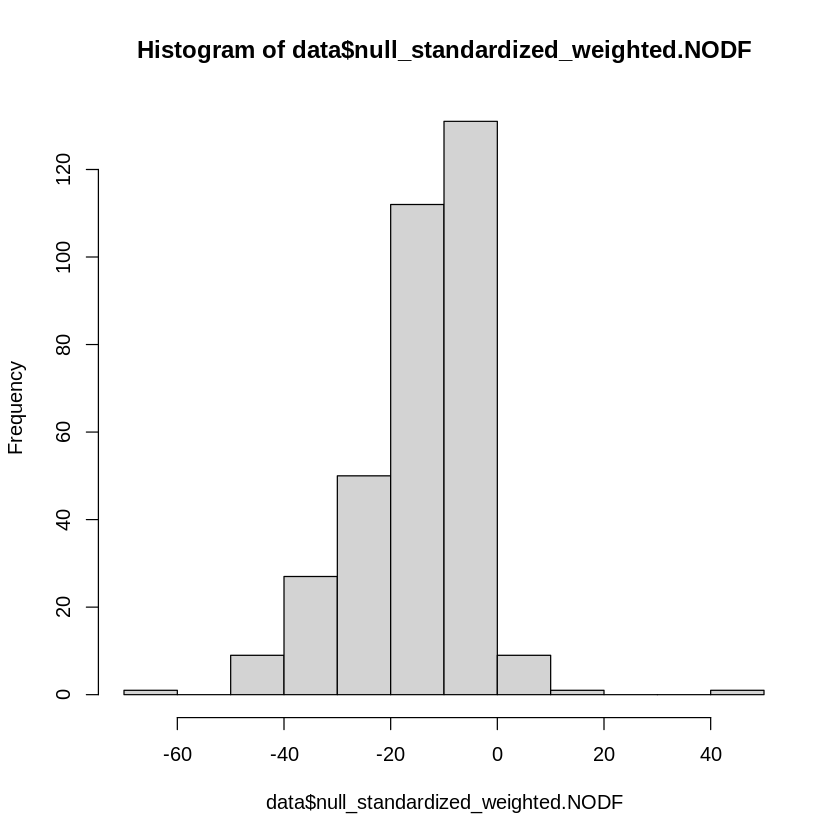

In [5]:
hist(data$null_standardized_weighted.NODF)

In [6]:
shapiro.test(data$null_standardized_weighted.NODF)


	Shapiro-Wilk normality test

data:  data$null_standardized_weighted.NODF
W = 0.93008, p-value = 1.484e-11


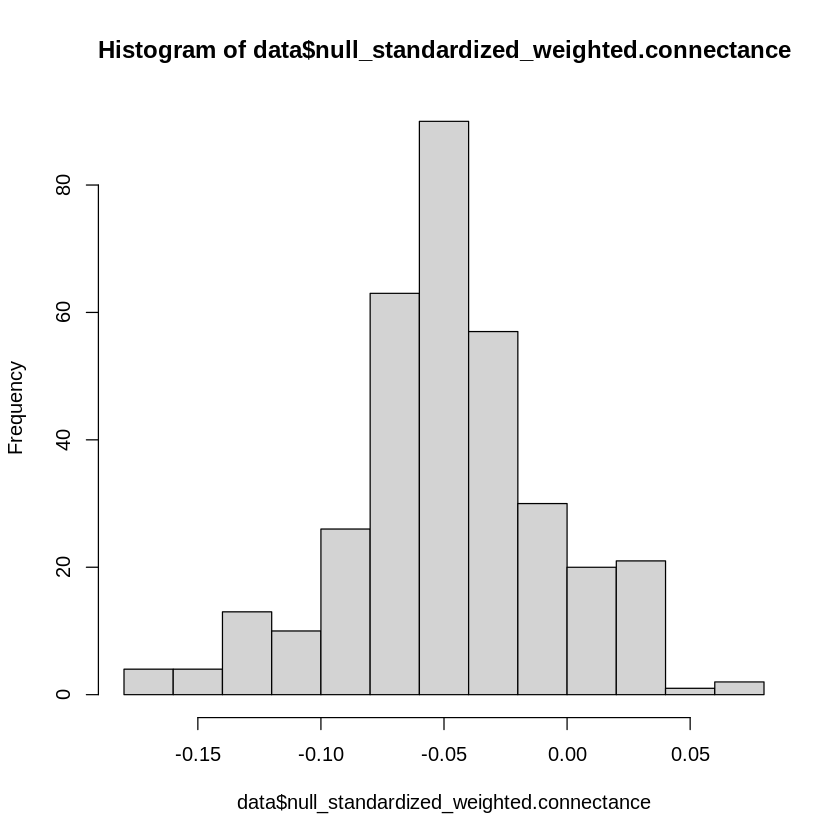

In [7]:
hist(data$null_standardized_weighted.connectance)

In [8]:
shapiro.test(data$null_standardized_weighted.connectance)


	Shapiro-Wilk normality test

data:  data$null_standardized_weighted.connectance
W = 0.98059, p-value = 0.0001466


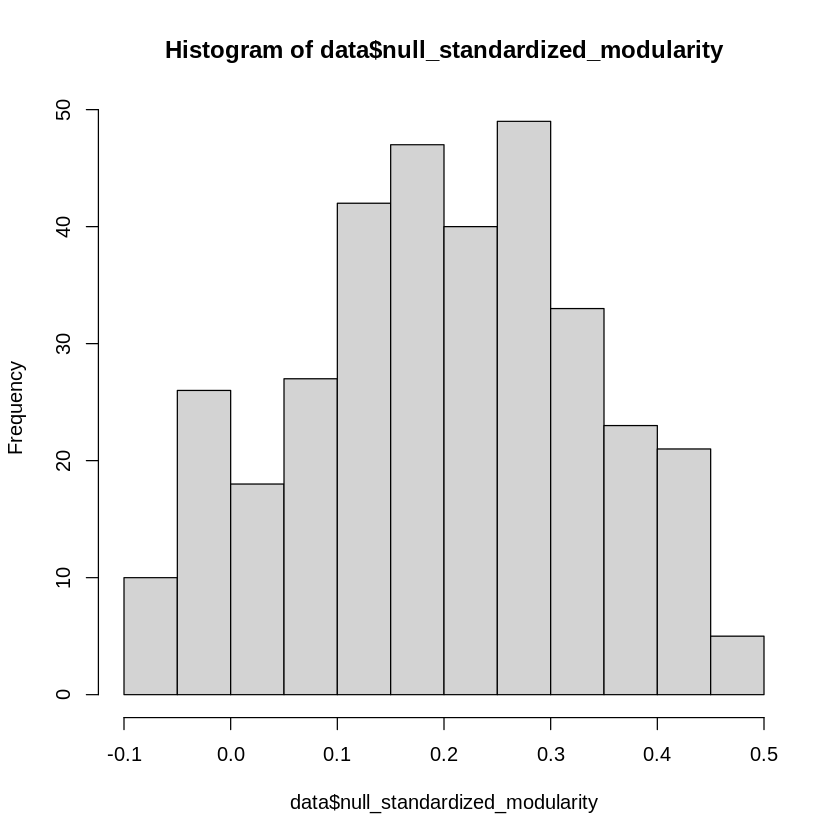

In [9]:
hist(data$null_standardized_modularity)

In [10]:
shapiro.test(data$null_standardized_modularity)


	Shapiro-Wilk normality test

data:  data$null_standardized_modularity
W = 0.98278, p-value = 0.0004203


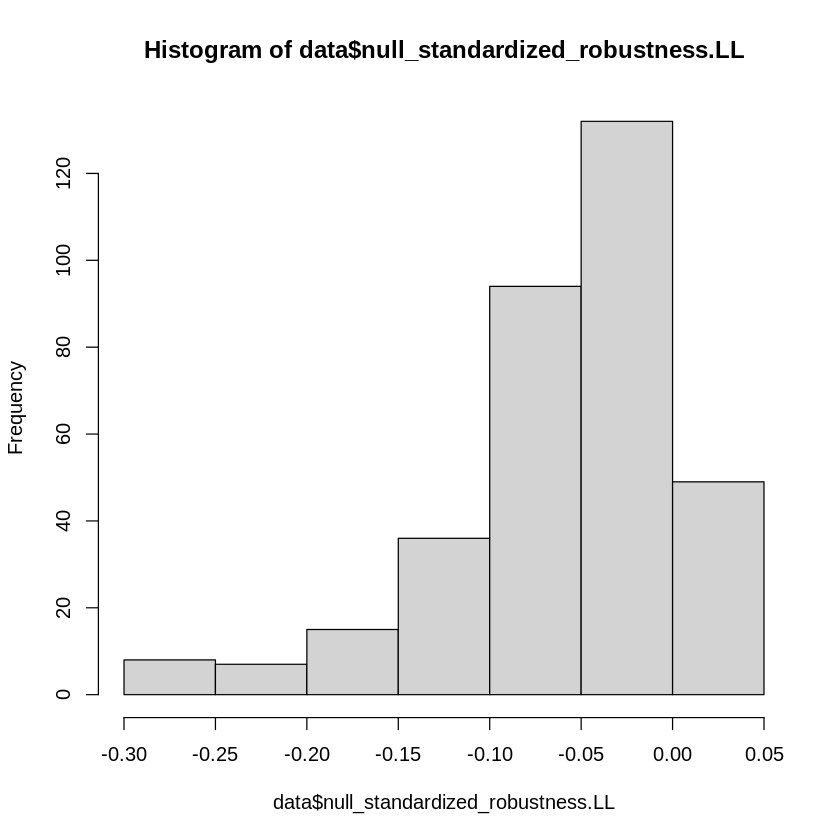

In [11]:
hist(data$null_standardized_robustness.LL)

In [12]:
shapiro.test(data$null_standardized_robustness.LL)


	Shapiro-Wilk normality test

data:  data$null_standardized_robustness.LL
W = 0.88354, p-value = 2.029e-15


# test for moderated effect of polyploids frequency

In [19]:
test_moderation <- function(response, predictor)
{
    #compute a model where the effect of status is estimated
    predictors = c(ploidy_predictor, "is_polyploid_missing_frac", "pd", "network_size")
    for (pred in predictor)
        predictors = c(predictors, c(pred, glue(pred, "*", ploidy_predictor)))
    data = drop_na(data, any_of(predictor))
    print(glue("# samples = ", dim(data)[1]))
    
    random_covars_formula_str = paste0("(1|", paste0(as.list(random_vars), collapse = ") + (1|"), ")")
    base_formula_str = glue(response, " ~ ", random_covars_formula_str)
    full_formula_str = base_formula_str
    for (pred in predictors) 
    {
        full_formula_str = glue(full_formula_str, " + ", pred)
    }
    
    res_df <- data.frame(matrix(ncol = 4, nrow = length(predictors)+1)) # +1 for intercept
    x <- c("response", "predictor", "lrt_statistic", "lrt_pvalue")
    colnames(res_df) <- x
    res_df["response"] = rep(response, length(predictors)+1) # +1 for intercept
    res_df["predictor"] = c(predictors, c("Intercept"))
    rownames(res_df) <-res_df$predictor

    unrestricted_fit = lmer(formula = as.formula(full_formula_str), REML = F, data=data) #because we want to compare models on likelihood
    fixed_vars_res = summary(unrestricted_fit)$coefficients
    print(r2_nakagawa(unrestricted_fit))
    simulateResiduals(unrestricted_fit, n=1000, plot=T)

    rownames(fixed_vars_res) = c("Intercept", predictors)
    colnames(fixed_vars_res) =  c("coefficient", "standard_error", "df", "t_test_statistic", "t_test_pvalue")

    res_df = merge(res_df, fixed_vars_res, by=0, all=T)
    rownames(res_df) <-res_df$Row.names
    
    for (pred in predictors)
    {
        formula_str = base_formula_str
        for (p in predictors)
        {
        if (p != pred & p != glue(pred, "*", ploidy_predictor))
            {
                formula_str = glue(formula_str, " + ", p)
            }
        }
        restricted_fit = lmer(formula = as.formula(formula_str), REML = F, data=data) #because we want to compare models on likelihood
        lrt <- anova(unrestricted_fit, restricted_fit)
        lrt_val = lrt["unrestricted_fit","Chisq"]
        p_val = lrt["unrestricted_fit","Pr(>Chisq)"]
        res_df[pred, "lrt_statistic"] = ifelse(is.na(lrt_val), 0, lrt_val)
        res_df[pred, "lrt_pvalue"] = ifelse(is.na(p_val), 1, p_val)
        
    }
    rownames(res_df) = NULL
    res_df <- subset(res_df, select = -Row.names)
    res_df <- res_df[order(res_df$predictor),]
    return (res_df)
}

round_df <- function(df, digits = 5) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))

  df[,nums] <- round(df[,nums], digits = digits)

  (df)
}

## connectance

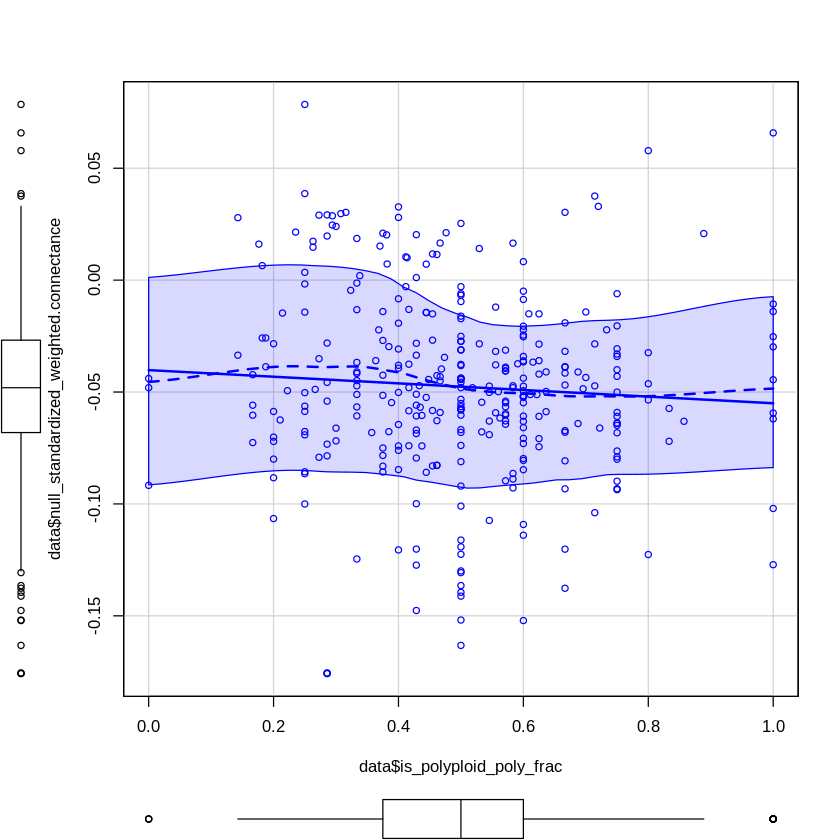

In [14]:
scatterplot(data$is_polyploid_poly_frac, data$null_standardized_weighted.connectance)

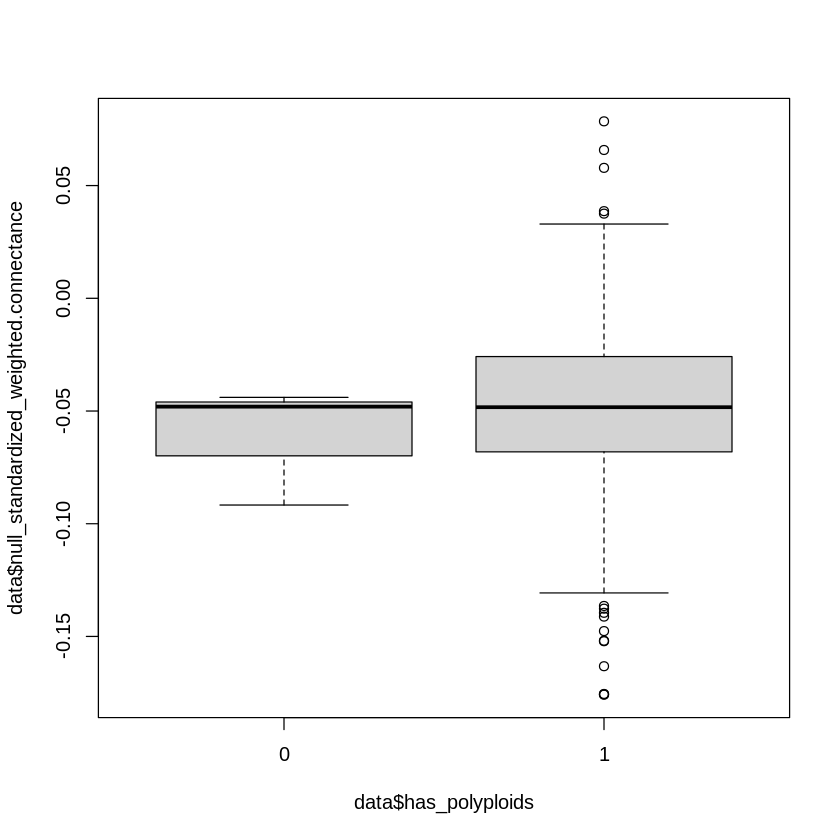

In [15]:
boxplot(data$null_standardized_weighted.connectance ~ data$has_polyploids)

# samples = 341
# R2 for Mixed Models

  Conditional R2: 0.315
     Marginal R2: 0.170


boundary (singular) fit: see help('isSingular')



,response,predictor,lrt_statistic,lrt_pvalue,coefficient,standard_error,df,t_test_statistic,t_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,null_standardized_weighted.connectance,frac_flw_rest,7.35163,0.02533,-0.05395,0.02807,335.07222,-1.92209,0.05544
2,null_standardized_weighted.connectance,frac_flw_rest*is_polyploid_poly_frac,1.03205,0.30968,-0.01864,0.01860,339.54761,-1.00207,0.31702
3,null_standardized_weighted.connectance,frac_sc,1.71334,0.42457,0.00570,0.00386,339.16583,1.47823,0.14027
4,null_standardized_weighted.connectance,frac_sc*is_polyploid_poly_frac,0.34097,0.55927,0.05460,0.05370,340.90462,1.01680,0.30997
5,null_standardized_weighted.connectance,Intercept,NA,NA,-0.12503,0.02359,88.63684,-5.30087,0.00000
6,null_standardized_weighted.connectance,is_polyploid_missing_frac,0.75559,0.38471,0.01346,0.01519,323.16785,0.88610,0.37622
7,null_standardized_weighted.connectance,is_polyploid_poly_frac,0.00000,1.00000,-0.02158,0.03583,314.75452,-0.60214,0.54752
8,null_standardized_weighted.connectance,network_size,37.58050,0.00000,0.01140,0.00178,331.11925,6.40071,0.00000
9,null_standardized_weighted.connectance,pd,1.70978,0.19101,0.00020,0.00016,339.27337,1.30976,0.19116


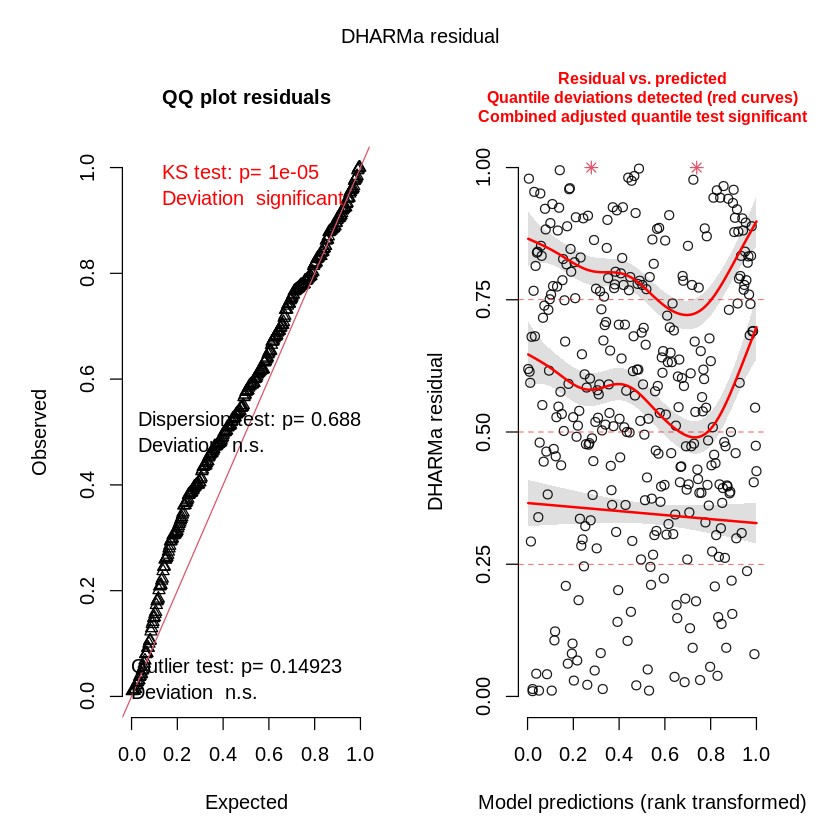

In [20]:
cont_res_df = test_moderation(response="null_standardized_weighted.connectance", predictor = c("frac_flw_rest", "frac_sc", "species_richness"))#, "Species.richness", 'Perennial.herb..', "Polyploid.percent"))
round_df(cont_res_df)

## nestedness

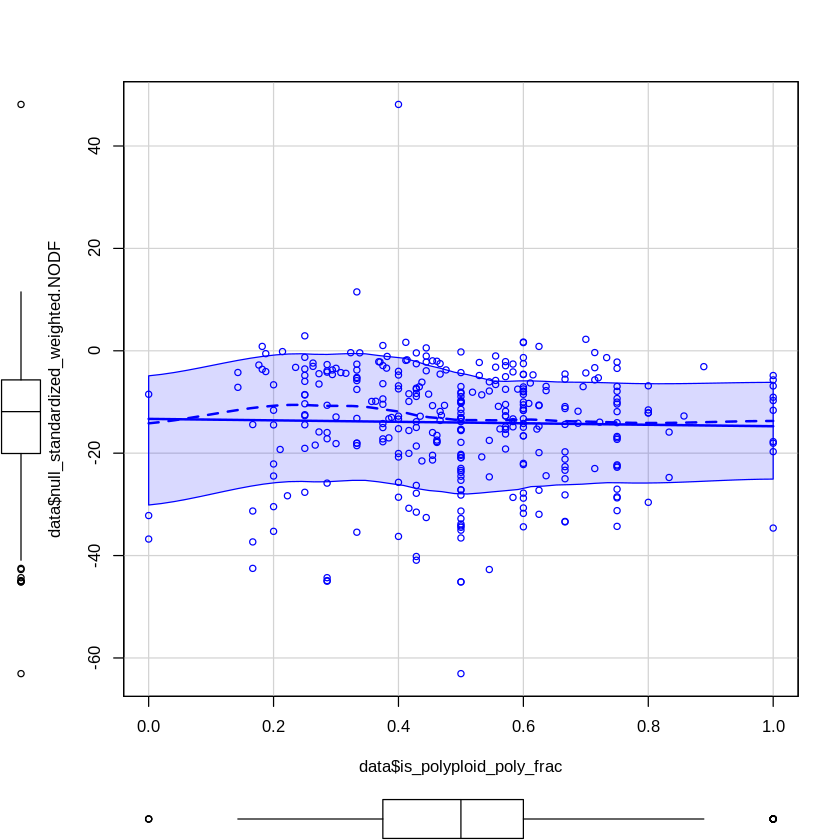

In [21]:
scatterplot(data$is_polyploid_poly_frac, data$null_standardized_weighted.NODF)

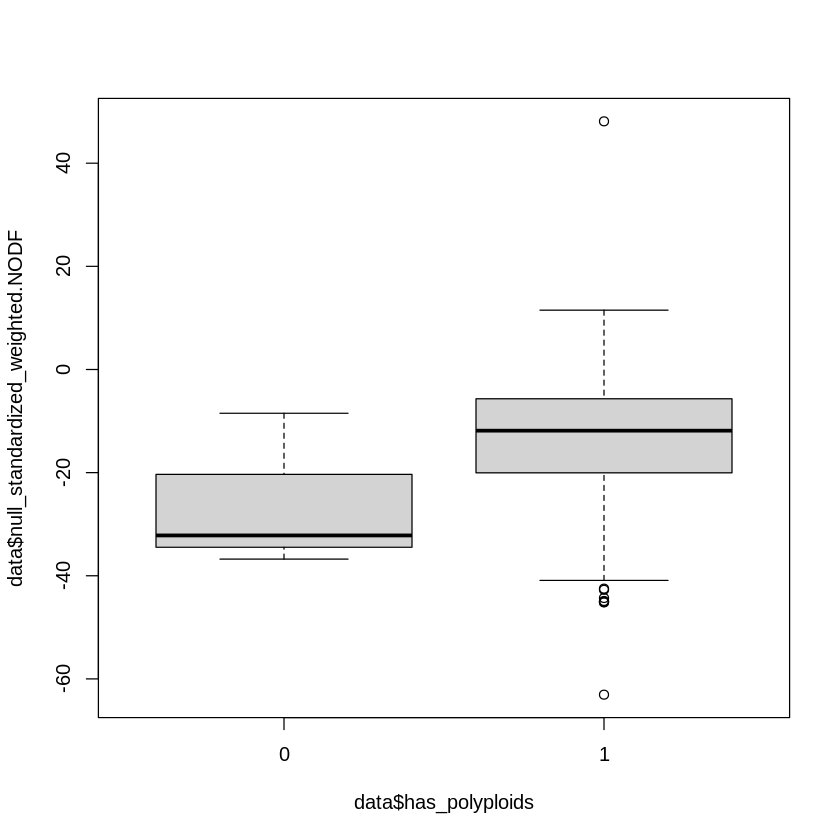

In [22]:
boxplot(data$null_standardized_weighted.NODF ~ data$has_polyploids)

# samples = 341


boundary (singular) fit: see help('isSingular')

Warning message:
“Can't compute random effect variances. Some variance components equal
  zero. Your model may suffer from singularity (see `?lme4::isSingular`
  and `?performance::check_singularity`).
  Solution: Respecify random structure! You may also decrease the
  `tolerance` level to enforce the calculation of random effect variances.”


Random effect variances not available. Returned R2 does not account for random effects.
# R2 for Mixed Models

  Conditional R2: NA
     Marginal R2: 0.180


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



,response,predictor,lrt_statistic,lrt_pvalue,coefficient,standard_error,df,t_test_statistic,t_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,null_standardized_weighted.NODF,frac_flw_rest,9.44970,0.00887,-24.14119,7.91840,337.7160,-3.04875,0.00248
2,null_standardized_weighted.NODF,frac_flw_rest*is_polyploid_poly_frac,9.04565,0.00263,-10.08412,5.23319,335.8190,-1.92695,0.05483
3,null_standardized_weighted.NODF,frac_sc,3.84546,0.14621,-0.01858,1.06948,332.4879,-0.01738,0.98615
4,null_standardized_weighted.NODF,frac_sc*is_polyploid_poly_frac,2.56709,0.10911,45.31534,14.88084,340.0507,3.04521,0.00251
5,null_standardized_weighted.NODF,Intercept,NA,NA,-20.37664,6.15097,207.9343,-3.31275,0.00109
6,null_standardized_weighted.NODF,is_polyploid_missing_frac,5.04903,0.02464,9.55856,4.11012,337.7194,2.32562,0.02063
7,null_standardized_weighted.NODF,is_polyploid_poly_frac,0.00000,1.00000,-17.68774,9.61356,338.1713,-1.83987,0.06666
8,null_standardized_weighted.NODF,network_size,25.37767,0.00000,2.69838,0.45579,340.9856,5.92024,0.00000
9,null_standardized_weighted.NODF,pd,0.00424,0.94807,-0.00279,0.04273,335.3932,-0.06521,0.94805


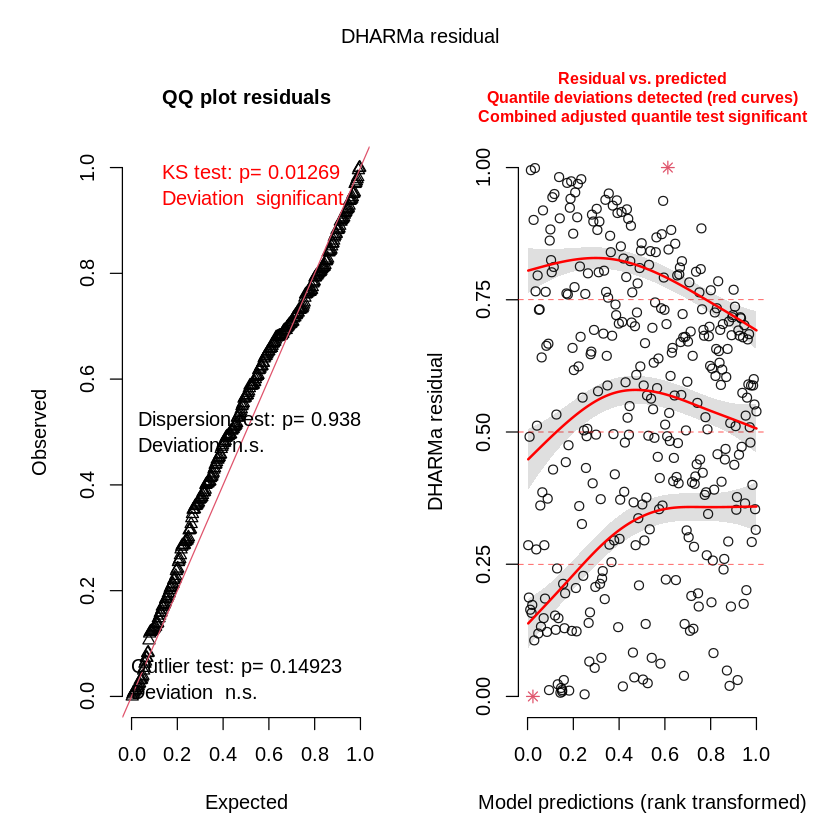

In [23]:
nest_res_df = test_moderation(response="null_standardized_weighted.NODF", predictor = c("frac_flw_rest", "frac_sc", "species_richness"))#, covars=c("Climate_PC1", "Climate_PC2", "Climate_PC3"))#, "Species.richness", 'Perennial.herb..', "Polyploid.percent"))
round_df(nest_res_df)

## modularity

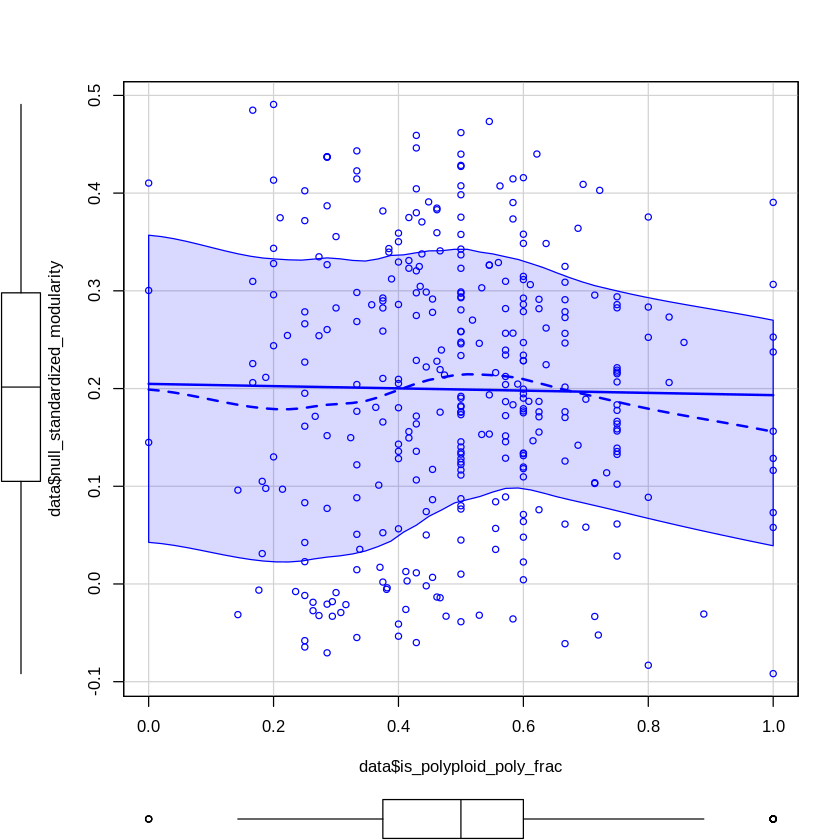

In [24]:
scatterplot(data$is_polyploid_poly_frac, data$null_standardized_modularity)

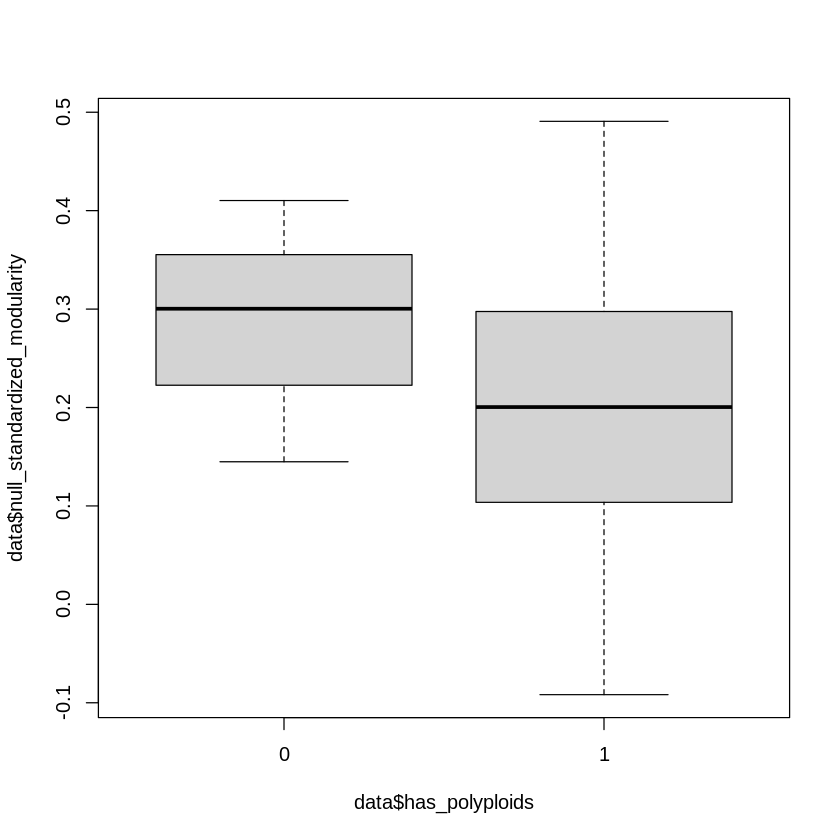

In [25]:
boxplot(data$null_standardized_modularity ~ data$has_polyploids)

# samples = 341


boundary (singular) fit: see help('isSingular')

Warning message:
“Can't compute random effect variances. Some variance components equal
  zero. Your model may suffer from singularity (see `?lme4::isSingular`
  and `?performance::check_singularity`).
  Solution: Respecify random structure! You may also decrease the
  `tolerance` level to enforce the calculation of random effect variances.”


Random effect variances not available. Returned R2 does not account for random effects.
# R2 for Mixed Models

  Conditional R2: NA
     Marginal R2: 0.120


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



,response,predictor,lrt_statistic,lrt_pvalue,coefficient,standard_error,df,t_test_statistic,t_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,null_standardized_modularity,frac_flw_rest,6.16839,0.04577,0.21319,0.09785,339.0606,2.17882,0.03003
2,null_standardized_modularity,frac_flw_rest*is_polyploid_poly_frac,2.45452,0.11719,0.11141,0.06465,338.0054,1.72325,0.08576
3,null_standardized_modularity,frac_sc,3.00677,0.22238,-0.03786,0.01324,338.8497,-2.85855,0.00452
4,null_standardized_modularity,frac_sc*is_polyploid_poly_frac,2.21938,0.13629,-0.28911,0.18395,340.1687,-1.57165,0.11696
5,null_standardized_modularity,Intercept,NA,NA,0.31577,0.07668,245.1284,4.11814,0.00005
6,null_standardized_modularity,is_polyploid_missing_frac,1.77984,0.18217,-0.06867,0.05088,340.2221,-1.34969,0.17801
7,null_standardized_modularity,is_polyploid_poly_frac,0.00000,1.00000,0.04827,0.11899,340.4948,0.40568,0.68523
8,null_standardized_modularity,network_size,1.15777,0.28193,-0.00609,0.00564,340.6039,-1.08085,0.28053
9,null_standardized_modularity,pd,2.52415,0.11212,-0.00084,0.00053,338.3736,-1.59195,0.11233


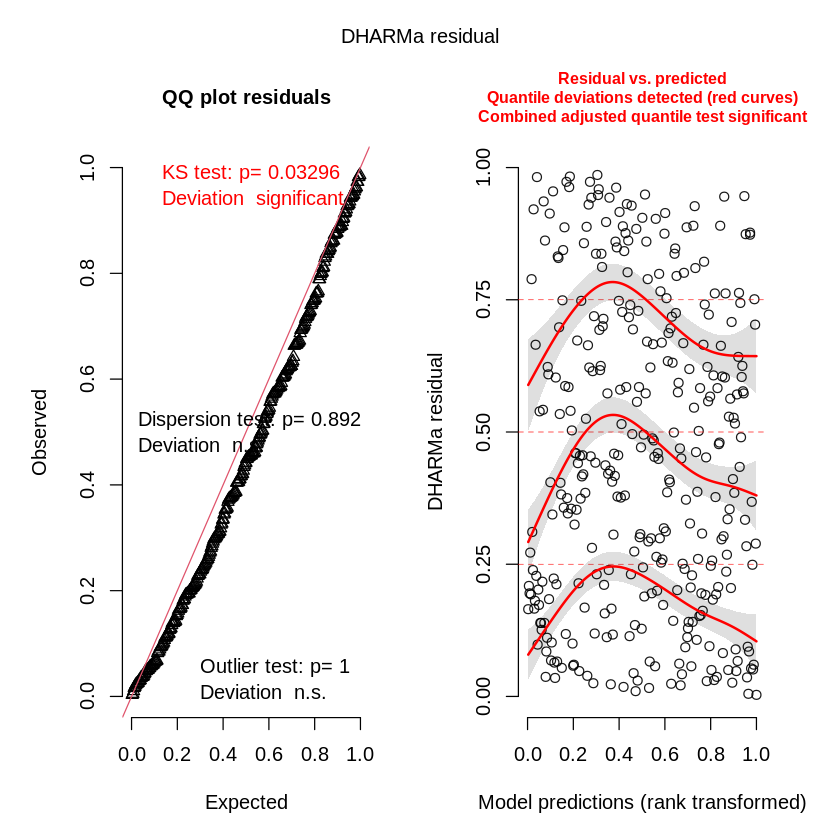

In [26]:
modul_res_df = test_moderation(response="null_standardized_modularity", predictor= c("frac_flw_rest", "frac_sc", "species_richness"))#, "Species.richness", 'Perennial.herb..', "Polyploid.percent"))
round_df(modul_res_df)

## robustness

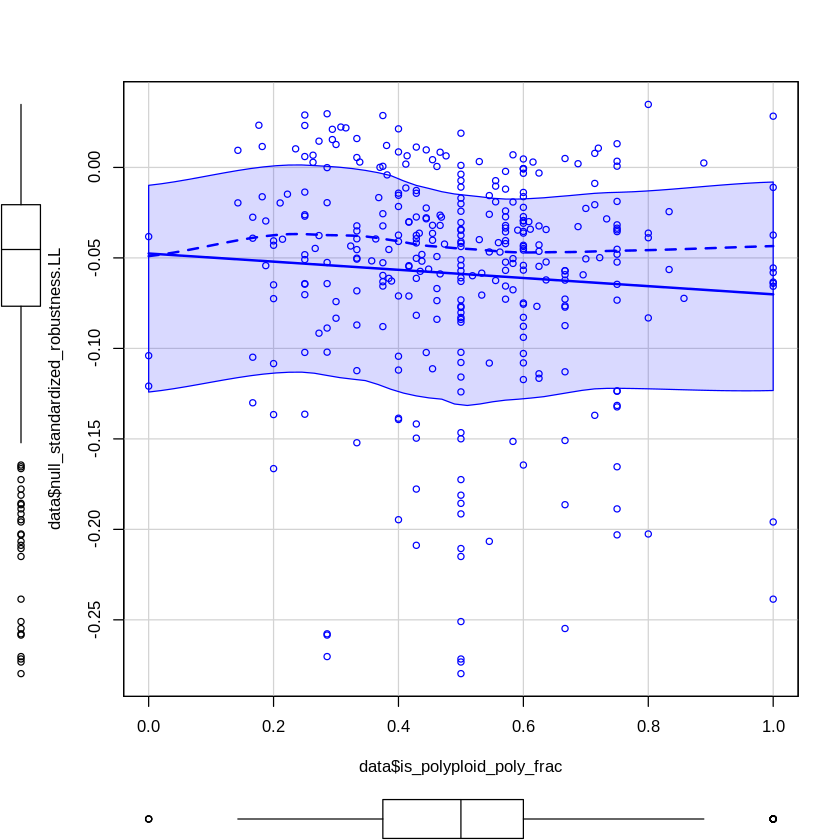

In [27]:
scatterplot(data$is_polyploid_poly_frac, data$null_standardized_robustness.LL)

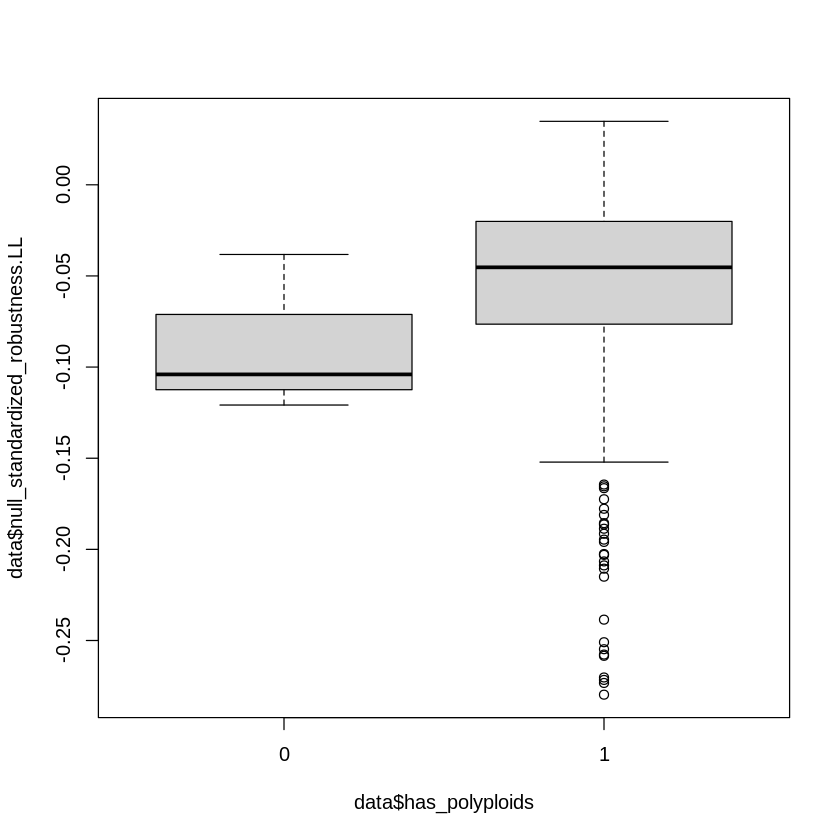

In [28]:
boxplot(data$null_standardized_robustness.LL ~ data$has_polyploids)

# samples = 341
# R2 for Mixed Models

  Conditional R2: 0.362
     Marginal R2: 0.089


,response,predictor,lrt_statistic,lrt_pvalue,coefficient,standard_error,df,t_test_statistic,t_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,null_standardized_robustness.LL,frac_flw_rest,4.70635,0.09507,-0.07357,0.04087,336.03874,-1.80022,0.07272
2,null_standardized_robustness.LL,frac_flw_rest*is_polyploid_poly_frac,1.42511,0.23256,-0.03806,0.02720,339.62837,-1.39912,0.16269
3,null_standardized_robustness.LL,frac_sc,2.05239,0.35837,0.00485,0.00561,333.33777,0.86440,0.38799
4,null_standardized_robustness.LL,frac_sc*is_polyploid_poly_frac,1.29091,0.25588,0.09372,0.07837,336.71993,1.19589,0.23258
5,null_standardized_robustness.LL,Intercept,NA,NA,-0.13430,0.03604,85.83315,-3.72671,0.00035
6,null_standardized_robustness.LL,is_polyploid_missing_frac,0.54501,0.46036,0.01691,0.02218,321.07109,0.76230,0.44644
7,null_standardized_robustness.LL,is_polyploid_poly_frac,0.00000,1.00000,0.00818,0.05256,337.05755,0.15567,0.87639
8,null_standardized_robustness.LL,network_size,19.43645,0.00001,0.01176,0.00261,339.46319,4.51265,0.00001
9,null_standardized_robustness.LL,pd,0.15156,0.69705,0.00009,0.00023,338.79756,0.39002,0.69677


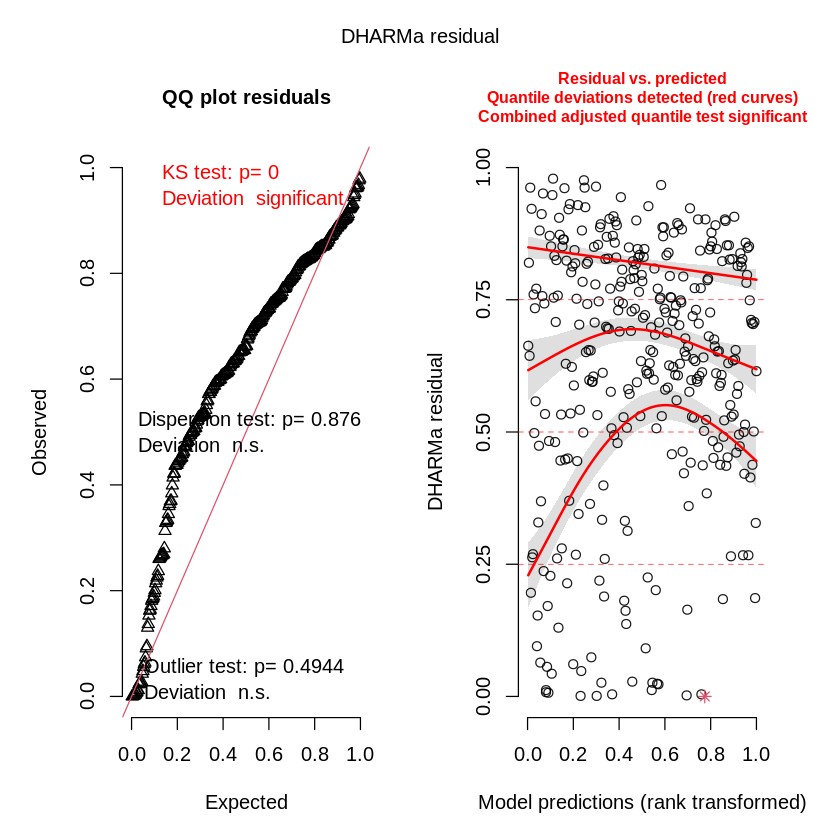

In [29]:
rob_res_df = test_moderation(response="null_standardized_robustness.LL", predictor= c("frac_flw_rest", "frac_sc", "species_richness"))#, "Species.richness", 'Perennial.herb..', "Polyploid.percent"))
round_df(rob_res_df)

In [30]:
full_df = rbind(rbind(rbind(nest_res_df, cont_res_df), modul_res_df), rob_res_df)

In [34]:
full_df["significant"] = full_df$lrt_pvalue <= 0.05
full_df[full_df$significant == TRUE, ]

,response,predictor,lrt_statistic,lrt_pvalue,coefficient,standard_error,df,t_test_statistic,t_test_pvalue,significant
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,null_standardized_weighted.NODF,frac_flw_rest,9.449697,8.872056e-03,-24.14119191,7.918401562,337.7160,-3.048746,2.479438e-03,TRUE
2,null_standardized_weighted.NODF,frac_flw_rest*is_polyploid_poly_frac,9.045645,2.633213e-03,-10.08412362,5.233191188,335.8190,-1.926955,5.482869e-02,TRUE
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,null_standardized_weighted.NODF,is_polyploid_missing_frac,5.049031,2.463971e-02,9.55856213,4.110120089,337.7194,2.325616,2.063082e-02,TRUE
8,null_standardized_weighted.NODF,network_size,25.377666,4.713435e-07,2.69837877,0.455789029,340.9856,5.920236,7.841461e-09,TRUE
12,null_standardized_weighted.connectance,frac_flw_rest,7.351629,2.532877e-02,-0.05394827,0.028067545,335.0722,-1.922087,5.544252e-02,TRUE
NA.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
19,null_standardized_weighted.connectance,network_size,37.580499,8.771707e-10,0.01140454,0.001781762,331.1192,6.400711,5.287193e-10,TRUE
23,null_standardized_modularity,frac_flw_rest,6.168387,4.576693e-02,0.21318875,0.097846041,339.0606,2.178818,3.003332e-02,TRUE


In [31]:
write.csv(full_df, res_path)

# test for mediated effect of polyploids frequency

In [ ]:
test_mediation <- function(response, data=data)
{
    print(glue("# samples = ", dim(data)[1]))
    predicting_ploidy = c("is_woody")
    predciting_response = c("is_woody", "is_flw_rest") #, "is_sc", "is_inflor_multiple", "transformed_flw_len", "is_flw_zygomorphic")
    
    # to ploidy model
    to_ploidy_formula_str = glue(ploidy_predictor, " ~ ")
    for (pred in predicting_ploidy)
        {
        to_ploidy_formula_str = glue(to_ploidy_formula_str, " + ", pred)
        }
    to_ploidy_model = glm(formula=as.formula(to_ploidy_formula_str), data=data)
    
    # by polyploidy
    to_flw_shape_model = glmer(formula=as.formula(glue("frac_flw_rest ~ ", ploidy_predictor, plv_str)), family="binomial", data=data)
    # to_flw_len_model = glmer(formula=as.formula(glue("var_flw_len ~ ", ploidy_predictor, plv_str)), family="gaussian", data=data)
    to_flw_nflor_model = glmer(formula=as.formula(glue("frac_symmetric ~ ", ploidy_predictor, plv_str)), family="binomial", data=data)
    to_flw_sym_model = glmer(formula=as.formula(glue("frac_sc ~ ", ploidy_predictor, plv_str)), family="binomial", data=data)
    to_ms = glmer(formula=as.formula(glue("is_sc ~ ", ploidy_predictor, plv_str)), family="binomial", data=data)
    
    # to response model                                   
    to_response_formula_str = glue(response, " ~ (1|network_index) + ", ploidy_predictor, plv_str)
    for (pred in predciting_response)
        {
        to_response_formula_str = glue(to_response_formula_str, " + ", pred)
        }
    to_response_model = glmer(to_response_formula_str, family="gaussian", data=data)
    
    psem = psem(to_flw_shape_model,
                #to_flw_len_model
                #to_flw_nflor_model,
                #to_flw_sym_model,
                # to_ms,
                to_ploidy_model,
                to_response_model)
    print(LLchisq(psem))
    print(summary(psem))
    return (psem)
}

verify_resp_model <- function(response) 
{
    predciting_response = c("is_woody", "is_flw_rest") #, "is_sc", "is_inflor_multiple", "transformed_flw_len", "is_flw_zygomorphic")
    to_response_formula_str = glue(response, " ~ (1|network_index) + ", ploidy_predictor, plv_str)
    for (pred in predciting_response)
        {
        to_response_formula_str = glue(to_response_formula_str, " + ", pred)
        }
    to_response_model <- glmmTMB(formula=as.formula(to_response_formula_str)
                        , family=ordbeta(link = "logit")
                        , ziformula=~1
                        , dispformula = ~1
                        , data=data
                        , control = glmmTMBControl(optimizer = optim, optArgs = list(method="BFGS")) # for d, shanno diversity and closeness
                        )
    return (to_response_model)

}